In [1]:

DB_ULR = "neo4j://localhost:7687"
DB_USER = "neo4j"
DB_PASS = "test1234"
DB_NAME = "symptom"

# Create driver
Also set the DB_NAME

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px 
from neo4j import GraphDatabase # Python database driver
from graphdatascience import GraphDataScience # Python GDS client

# And some cermony to create the driver and gds objects
driver = GraphDatabase.driver(DB_ULR, auth=(DB_USER, DB_PASS))
gds = GraphDataScience(DB_ULR, auth=(DB_USER, DB_PASS))
gds.set_database(DB_NAME)

# Create databse and schema

In [3]:
# Create (or replace) database
with driver.session(database = "system") as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            "CREATE OR REPLACE DATABASE {dbname}".format(dbname = DB_NAME)
        ).data()
    )

In [4]:
# Create indexes and constraints
with driver.session(database = DB_NAME) as session:
    session.write_transaction( lambda tx: 
        tx.run(
            "CREATE CONSTRAINT IF NOT EXISTS FOR (n:Symptom) REQUIRE (n.name) IS NODE KEY"
        ).consume()
    )
    session.write_transaction( lambda tx: 
        tx.run(
            "CREATE CONSTRAINT IF NOT EXISTS FOR (n:Disease) REQUIRE (n.name) IS NODE KEY"
        ).consume()     
    )

#  Load data

In [5]:
# Read csv file
# Source https://github.com/deshanadesai/Symptom-X-/blob/master/dataset_clean1.csv
csv = pd.read_csv('https://raw.githubusercontent.com/deshanadesai/Symptom-X-/master/dataset_clean1.csv')
csv.head()

,Source,Target,Weight
0,influenza,uncoordination,68
1,influenza,fever,68
2,influenza,pleuritic pain,68
3,influenza,snuffle,68
4,influenza,throat sore,68


In [6]:
# Select all unique symptoms
symptoms = csv['Target'].drop_duplicates().dropna()
symptoms.head()

0    uncoordination
1             fever
2    pleuritic pain
3           snuffle
4       throat sore
Name: Target, dtype: object

In [7]:
# Create Symptom nodes
for chunk in np.array_split(symptoms, 2):
    with driver.session(database = DB_NAME) as session:
        result = session.write_transaction( lambda tx: 
            tx.run(
                """
                UNWIND $symptoms as symptomName
                MERGE (:Symptom{name: symptomName})
                RETURN count(*) as nodesCreated
                """,
                symptoms = chunk.to_list()
            ).data()
        )
        df = pd.DataFrame(result)
df.head()

,nodesCreated
0,202


In [8]:
# Select all unique diseases
diseases = csv['Source'].drop_duplicates().dropna()
diseases.head()

0                influenza
21               gastritis
33    hypercholesterolemia
48                epilepsy
61     insufficiency renal
Name: Source, dtype: object

In [9]:
# Create Disease nodes
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            UNWIND $diseases as diseaseName
            MERGE (:Disease{name: diseaseName})
            RETURN count(*) as nodesCreated
            """,
            diseases = diseases.to_list()
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,nodesCreated
0,148


In [10]:
# Select all SYMPTOM_OV relationships
symptom_of_rels = csv[['Source','Target', 'Weight']]
df.head()

,nodesCreated
0,148


In [11]:
# Create VIEWED relationships
for chunk in np.array_split(symptom_of_rels, 2):
    with driver.session(database = DB_NAME) as session:
        result = session.write_transaction( lambda tx: 
            tx.run(
                """
                UNWIND $data as rel
                MATCH (d:Disease{name: rel.Source}), (s:Symptom{name: rel.Target})
                MERGE (s)-[:SYMPTOM_OF{weight:toInteger(rel.Weight)}]->(d)
                RETURN count(*) as relsCreated
                """,
                data = chunk.to_dict('records')
            ).data()
        )
        df = pd.DataFrame(result)
df.head()

,relsCreated
0,1062


# Some basic queries

In [12]:
# Syptom with highest degree
# Question: What does does it mean?
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s:Symptom)-[r:SYMPTOM_OF]->(d:Disease)
            RETURN 
                s.name as symptom, 
                collect(d.name) as diseases, 
                count(d) as number_of_diseases
            ORDER BY number_of_diseases DESC LIMIT $limit
            """,
            limit = 5
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,symptom,diseases,number_of_diseases
0,shortness of breath,"[adhesion, anemia, arthritis, asthma, bronchit...",49
1,pain,"[adenocarcinoma, adhesion, anemia, anxiety sta...",44
2,fever,"[Alzheimer's disease, HIV, acquired immuno-def...",38
3,diarrhea,"[HIV, Pneumocystis carinii pneumonia, acquired...",30
4,pain abdominal,"[adenocarcinoma, biliary calculus, carcinoma c...",29


In [13]:
# Syptom with lowest degree
# Question: What does does it mean?
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s:Symptom)-[r:SYMPTOM_OF]->(d:Disease)
            RETURN 
                s.name as symptom, 
                collect(d.name) as diseases, 
                count(d) as number_of_diseases
            ORDER BY number_of_diseases ASC LIMIT $limit
            """,
            limit = 3
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,symptom,diseases,number_of_diseases
0,tremor resting,[Alzheimer's disease],1
1,pin-point pupils,[Alzheimer's disease],1
2,drool,[Alzheimer's disease],1


In [14]:
# Possible diseases given two symptoms
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s1:Symptom{name:"fever"})-[:SYMPTOM_OF]->(d:Disease)<-[:SYMPTOM_OF]-(s2:Symptom{name:"swelling"})
            RETURN d.name as disease
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,disease
0,osteomyelitis
1,exanthema
2,cellulitis
3,infection
4,lymphatic diseases


In [15]:
# Possible diseases given two symptoms
# Weighted
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s1:Symptom{name:"fever"})-[r1:SYMPTOM_OF]->(d:Disease)<-[r2:SYMPTOM_OF]-(s2:Symptom{name:"swelling"})
            RETURN d.name as disease, 
                   r1.weight + r2.weight as weight 
            ORDER BY weight DESC 
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,disease,weight
0,infection,1260
1,cellulitis,682
2,chronic kidney failure,560
3,exanthema,416
4,lymphatic diseases,320


# Graph data science
Can we arrange syptoms based on diseases they share?

In [16]:
G1=gds.graph.project('p1',['Disease', 'Symptom'], ['SYMPTOM_OF'])
"Nodes: {node_count}, Relationships {relationship_count}".format(node_count=G1.node_count(), relationship_count=G1.relationship_count())

'Nodes: 552, Relationships 2110'

In [17]:
gds.nodeSimilarity.stats(G1, 
    similarityMetric = 'OVERLAP', 
    similarityCutoff = 0.6
)

{'preProcessingMillis': 0,
 'computeMillis': 6,
 'postProcessingMillis': 0,
 'nodesCompared': 404,
 'similarityPairs': 3362,
 'similarityDistribution': {'p1': 0.5999984741210938,
  'max': 1.0000038146972656,
  'p5': 0.6666641235351562,
  'p90': 1.0000038146972656,
  'p50': 1.0000038146972656,
  'p95': 1.0000038146972656,
  'p10': 0.75,
  'p75': 1.0000038146972656,
  'p99': 1.0000038146972656,
  'p25': 1.0000038146972656,
  'p100': 1.0000038146972656,
  'min': 0.5999984741210938,
  'mean': 0.9582757115860484,
  'stdDev': 0.10784796756708696},
 'configuration': {'topK': 10,
  'similarityMetric': 'OVERLAP',
  'bottomK': 10,
  'bottomN': 0,
  'relationshipWeightProperty': None,
  'topN': 0,
  'concurrency': 4,
  'degreeCutoff': 1,
  'similarityCutoff': 0.6,
  'nodeLabels': ['*'],
  'sudo': False,
  'relationshipTypes': ['*'],
  'username': None}}

In [18]:
gds.nodeSimilarity.write(G1, 
    similarityMetric = 'OVERLAP', 
    similarityCutoff = 0.6, 
    writeRelationshipType = 'NARROWER_THAN', 
    writeProperty = 'similarity'
)

{'preProcessingMillis': 0,
 'computeMillis': 6,
 'writeMillis': 73,
 'postProcessingMillis': -1,
 'nodesCompared': 404,
 'relationshipsWritten': 3362,
 'similarityDistribution': {'p1': 0.5999984741210938,
  'max': 1.0000038146972656,
  'p5': 0.6666641235351562,
  'p90': 1.0000038146972656,
  'p50': 1.0000038146972656,
  'p95': 1.0000038146972656,
  'p10': 0.75,
  'p75': 1.0000038146972656,
  'p99': 1.0000038146972656,
  'p25': 1.0000038146972656,
  'p100': 1.0000038146972656,
  'min': 0.5999984741210938,
  'mean': 0.9582757115860484,
  'stdDev': 0.10784796756708696},
 'configuration': {'topK': 10,
  'writeConcurrency': 4,
  'similarityMetric': 'OVERLAP',
  'bottomK': 10,
  'bottomN': 0,
  'relationshipWeightProperty': None,
  'topN': 0,
  'concurrency': 4,
  'writeProperty': 'similarity',
  'degreeCutoff': 1,
  'writeRelationshipType': 'NARROWER_THAN',
  'similarityCutoff': 0.6,
  'nodeLabels': ['*'],
  'sudo': False,
  'relationshipTypes': ['*'],
  'username': None}}

In [19]:
G1.drop()

In [20]:
# Touch-up: Remove symmetric NARROWER_THAN relationships
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s1:Symptom)-[r:NARROWER_THAN]->(s2:Symptom)
            WHERE (s2)-[:NARROWER_THAN]->(s1)
            DELETE r
            RETURN count(*) as relationships_deleted
            """,
            limit = 10, itemid = 461686, visitorid=684514
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,relationships_deleted
0,2184


In [21]:
# Touch-up: Make NARROWER_THAN point towards the node with the bigger set of adjacent Diseases
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s1:Symptom)-[r:NARROWER_THAN]->(s2:Symptom)
            WHERE size( (s1)-[:SYMPTOM_OF]->() ) > size( (s2)-[:SYMPTOM_OF]->() )
            CREATE (s2)-[:NARROWER_THAN{similarity: r.similarity}]->(s1)
            DELETE r
            RETURN count(*) as relationships_reversed
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,relationships_reversed
0,485


In [22]:
# Touch-up: Remove transitive dependencies
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s:Symptom)-[r:NARROWER_THAN]->(s2:Symptom)
            WHERE (s)-[:NARROWER_THAN*2..20]->(s2)
            DELETE r
            RETURN count(*) as relationships_transitive
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,relationships_transitive
0,242


In [23]:
# Let's query our new NARROWER_THAN relationships
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (l2:Symptom)-[:NARROWER_THAN]->(l1:Symptom)-[:NARROWER_THAN]->(root:Symptom{name:"pain"})
            RETURN l2.name + '->' + l1.name + '->' + root.name as path
            ORDER BY l2.name, l1.name
            """,
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,path
0,Murphy's sign->colic abdominal->pain
1,abdomen acute->flatulence->pain
2,abnormal sensation->fremitus->pain
3,ache->lung nodule->pain
4,air fluid level->flatulence->pain


## Conclusions
We have now learned the Taxonomy of our data :)

In [24]:
# Let's check what communities we have
# What type of graph is this?
G2=gds.graph.project('p2',['Symptom'], ['NARROWER_THAN'])
"Nodes: {node_count}, Relationships {relationship_count}".format(node_count=G2.node_count(), relationship_count=G2.relationship_count())

'Nodes: 404, Relationships 936'

In [25]:
gds.wcc.stats(G2)

{'componentCount': 26,
 'componentDistribution': {'p99': 378,
  'min': 1,
  'max': 378,
  'mean': 15.538461538461538,
  'p90': 1,
  'p50': 1,
  'p999': 378,
  'p95': 2,
  'p75': 1},
 'postProcessingMillis': 0,
 'preProcessingMillis': 0,
 'computeMillis': 1,
 'configuration': {'seedProperty': None,
  'consecutiveIds': False,
  'threshold': 0.0,
  'relationshipWeightProperty': None,
  'nodeLabels': ['*'],
  'sudo': False,
  'relationshipTypes': ['*'],
  'username': None,
  'concurrency': 4}}

In [26]:
gds.wcc.mutate(G2, mutateProperty='wccId')

{'mutateMillis': 0,
 'nodePropertiesWritten': 404,
 'componentCount': 26,
 'componentDistribution': {'p99': 378,
  'min': 1,
  'max': 378,
  'mean': 15.538461538461538,
  'p90': 1,
  'p50': 1,
  'p999': 378,
  'p95': 2,
  'p75': 1},
 'postProcessingMillis': 0,
 'preProcessingMillis': 0,
 'computeMillis': 1,
 'configuration': {'seedProperty': None,
  'consecutiveIds': False,
  'threshold': 0.0,
  'relationshipWeightProperty': None,
  'nodeLabels': ['*'],
  'sudo': False,
  'relationshipTypes': ['*'],
  'mutateProperty': 'wccId',
  'username': None,
  'concurrency': 4}}

In [27]:
gds.graph.writeNodeProperties(G2, ['wccId'])

{'writeMillis': 42,
 'graphName': 'p2',
 'nodeProperties': ['wccId'],
 'propertiesWritten': 404}

In [28]:
# Let's check the small iselands
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s:Symptom)
            WITH s.wccId as communityId, count(*) as communitySize where communitySize < 5
            MATCH (s:Symptom{wccId:communityId})
            RETURN communityId, 
                   collect(s.name) as symptoms, 
                   communitySize, 
                   [ (s)-[:SYMPTOM_OF]->(d) | d.name ] as diseases
            ORDER BY communityId
            """,
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,communityId,symptoms,communitySize,diseases
0,0,[uncoordination],1,"[encephalopathy, influenza]"
1,4,[throat sore],1,"[upper respiratory infection, spasm bronchial,..."
2,9,[scleral icterus],1,"[gastroenteritis, influenza]"
3,24,[disequilibrium],2,[gastritis]
4,24,[dizziness],2,"[hypertensive disease, hyperlipidemia, hemorrh..."


In [29]:
# Let's break down the largest community
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s:Symptom)
            WITH s.wccId as communityId, count(*) as communitySize
            RETURN communityId,communitySize order by communitySize desc limit 5
            """,
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,communityId,communitySize
0,1,378
1,24,2
2,4,1
3,9,1
4,0,1


In [30]:
wccId = df["communityId"][0]
print(wccId)


1


In [31]:
G3=gds.beta.graph.project.subgraph('p3', G2, 'n.wccId={id}'.format(id=wccId) , '*')
"Nodes: {node_count}, Relationships {relationship_count}".format(node_count=G3.node_count(), relationship_count=G3.relationship_count())

'Nodes: 378, Relationships 935'

In [32]:
gds.louvain.stats(G3)

{'modularity': 0.2970276530641425,
 'modularities': [0.2970276530641425],
 'ranLevels': 1,
 'communityCount': 108,
 'communityDistribution': {'p99': 19,
  'min': 1,
  'max': 19,
  'mean': 3.5,
  'p90': 7,
  'p50': 2,
  'p999': 19,
  'p95': 9,
  'p75': 4},
 'postProcessingMillis': 1,
 'preProcessingMillis': 0,
 'computeMillis': 148,
 'configuration': {'maxIterations': 10,
  'seedProperty': None,
  'consecutiveIds': False,
  'maxLevels': 10,
  'relationshipWeightProperty': None,
  'includeIntermediateCommunities': False,
  'nodeLabels': ['*'],
  'sudo': False,
  'relationshipTypes': ['*'],
  'tolerance': 0.0001,
  'concurrency': 4,
  'username': None}}

In [33]:
gds.louvain.write(G3, writeProperty='louvainId')

{'writeMillis': 42,
 'nodePropertiesWritten': 378,
 'modularity': 0.2970276530641425,
 'modularities': [0.2970276530641425],
 'ranLevels': 1,
 'communityCount': 108,
 'communityDistribution': {'p99': 19,
  'min': 1,
  'max': 19,
  'mean': 3.5,
  'p90': 7,
  'p50': 2,
  'p999': 19,
  'p95': 9,
  'p75': 4},
 'postProcessingMillis': 1,
 'preProcessingMillis': 0,
 'computeMillis': 33,
 'configuration': {'maxIterations': 10,
  'writeConcurrency': 4,
  'seedProperty': None,
  'consecutiveIds': False,
  'maxLevels': 10,
  'relationshipWeightProperty': None,
  'concurrency': 4,
  'writeProperty': 'louvainId',
  'includeIntermediateCommunities': False,
  'nodeLabels': ['*'],
  'sudo': False,
  'relationshipTypes': ['*'],
  'tolerance': 0.0001,
  'username': None}}

In [34]:
G3.drop()

In [35]:
G2.drop()

## Conclusions
Well, sometimes we fail. 100's of communities are not useful (see bloom). But then again, our NARROWER_THAN is a tree structure. So maybe we are better off just looking at what are the different tree roots. 

In [36]:
# Add Root label and also return roots
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (root:Symptom)<-[r:NARROWER_THAN*1..10]-(s:Symptom)
            WHERE NOT (root)-[:NARROWER_THAN]->()
            WITH root, count(distinct(s)) as treeSize
            SET root:Root, 
            root.treeSize = treeSize
            RETURN root.name as symptom, treeSize
            ORDER BY treeSize desc
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,symptom,treeSize
0,shortness of breath,78
1,pain,75
2,fever,47
3,decreased body weight,44
4,diarrhea,38


## Talke a look in neo4j bloom
Add the Root label to the scene, size the nodes by treeSize

In [37]:
# Set size for each node in the tree
with driver.session(database = DB_NAME) as session:
    result = session.write_transaction( lambda tx: 
        tx.run(
            """
            MATCH (s:Symptom)<-[r:NARROWER_THAN*0..10]-(n:Symptom)
            WITH s, count(distinct(n)) as treeSize
            SET s.treeSize = treeSize
            RETURN count(*) as nodesUpdated
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,nodesUpdated
0,404


In [38]:
# Grab some data so we can visualize it
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (root:Root)
            WITH root ORDER BY root.treeSize DESC LIMIT 3
            MATCH (l2:Symptom)-[:NARROWER_THAN]->(l1:Symptom)-[:NARROWER_THAN]->(root)
            RETURN l2.name as l2, l1.name as l1, root.name as root, l2.treeSize as size
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,l2,l1,root,size
0,hemianopsia homonymous,breath sounds decreased,shortness of breath,4
1,ache,haemoptysis,shortness of breath,1
2,tinnitus,haemoptysis,shortness of breath,1
3,welt,haemoptysis,shortness of breath,1
4,st segment elevation,orthopnea,shortness of breath,1


In [39]:
fig = px.sunburst(df, path=['root', 'l1', 'l2'], values='size', color='root')
fig.update_layout(title_text="Symptoms Hierarchy", font_size=10)
fig.show()

/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/plotly/express/_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/plotly/express/_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/plotly/express/_core.py:1594: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_trees = df_all_trees.append(df_tree, ignore_index=True)


## Important
We got 100+ roots, but to me they look more useful. Then again it depends in the question you want to answer.

We should of course have studied the tree strucuture to get familiar with our data before we even tried to formulate or answer any questions. 

# Let's pin our graph to the wall
A graphs are non eucledian, let's transform into an eucledian space. Node embeddings to the rescue


In [40]:
# Cypher projection of Diseases sharing symptoms
G4 = gds.graph.project.cypher('p4',
    """ MATCH (n:Disease)<-[:SYMPTOM_OF]-(s:Symptom)
        WHERE s.wccId = {wccId} 
        RETURN id(n) as id""".format(wccId=wccId),
    """ MATCH (n1:Disease)<-[:SYMPTOM_OF]-(s:Symptom)-[:SYMPTOM_OF]->(n2:Disease)
        WHERE s.wccId = {wccId} 
        RETURN id(n1) as source, id(n2) as target, count(*) as weight""".format(wccId=wccId)
)
"Nodes: {node_count}, Relationships {relationship_count}".format(node_count=G4.node_count(), relationship_count=G4.relationship_count())

'Nodes: 148, Relationships 12306'

In [41]:
gds.fastRP.write(G4, 
    embeddingDimension=16, 
    iterationWeights=[0.2, 1.0, 0.9, 0.7],
    nodeSelfInfluence=0.1,
    relationshipWeightProperty='weight', 
    writeProperty='embedding'
)

{'nodeCount': 148,
 'nodePropertiesWritten': 148,
 'preProcessingMillis': 0,
 'computeMillis': 2,
 'writeMillis': 51,
 'configuration': {'writeConcurrency': 4,
  'nodeSelfInfluence': 0.1,
  'relationshipWeightProperty': 'weight',
  'propertyRatio': 0.0,
  'concurrency': 4,
  'normalizationStrength': 0.0,
  'writeProperty': 'embedding',
  'iterationWeights': [0.2, 1.0, 0.9, 0.7],
  'embeddingDimension': 16,
  'nodeLabels': ['*'],
  'sudo': False,
  'relationshipTypes': ['*'],
  'featureProperties': [],
  'username': None}}

In [42]:
with driver.session(database = DB_NAME) as session:
    result = session.read_transaction( lambda tx: 
        tx.run(
            """
            MATCH (d:Disease)
            RETURN d.embedding as embedding, d.name as class
            """
        ).data()
    )
    df = pd.DataFrame(result)
df.head()

,embedding,class
0,"[1.0160614252090454, -0.5858619213104248, -0.4...",Alzheimer's disease
1,"[0.8564937710762024, -0.8285773992538452, -0.4...",HIV
2,"[0.7958560585975647, -0.7978115677833557, -0.3...",Pneumocystis carinii pneumonia
3,"[1.0425037145614624, -0.3927571773529053, -0.3...",accident cerebrovascular
4,"[0.851839542388916, -0.8047392964363098, -0.43...",acquired immuno-deficiency syndrome


In [43]:
embedding = df['embedding'].tolist()
category = df['class'].tolist()
Y = TSNE(n_components=2, perplexity=30, n_iter= 1000, learning_rate=200.0, early_exaggeration=12.0, verbose=1).fit_transform(embedding)

/Users/haklof/projects/public/notebooks/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 148 samples in 0.000s...
[t-SNE] Computed neighbors for 148 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 148 / 148
[t-SNE] Mean sigma: 0.228232
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.909298
[t-SNE] KL divergence after 1000 iterations: 0.307593


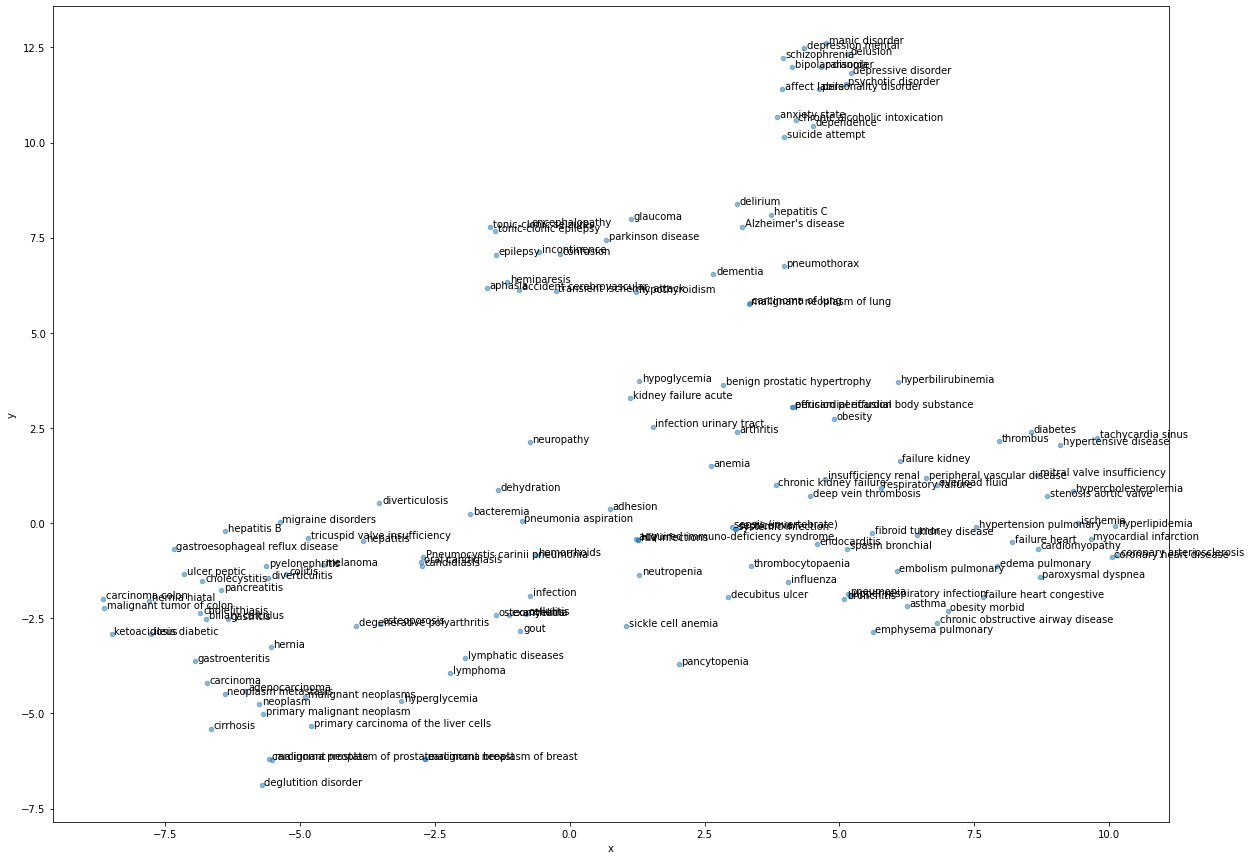

In [44]:
x_coords = Y[:, 0]
y_coords = Y[:, 1]
df = pd.DataFrame(list(zip(category, x_coords, y_coords)), columns=['label','x','y'] )
ax = df.plot.scatter(x='x', y='y', alpha=0.5, figsize=(20,15))
for index, row in df.iterrows():
   ax.annotate(row[0], (row[1]+0.05, row[2]))

In [45]:
G4.drop()